# 2.4. Jakość podziału: Gini impurity
Pierwszym i podstawowym sposobem pomiaru jakości podziału jest skorzystanie z tzw. Gini impurity. Jest to metoda dość intuicyjna, ale do jej zdefiniowania powróćmy na chwilę do proporcji, którą obliczaliśmy w poprzednich częściach.

W danym węźle drzewa obliczamy wartości pmk dla każdej z klas, które chcemy przewidywać. Są to wartości od 0 do 1 i określają jak dużo elementów przypisanych do danej etykiety znajduje się w tym węźle. Gdybyśmy chcieli więc określić jakie jest prawdopodobieństwo, że losując wybierzemy element należący do klasy X,  to musimy obliczyć wartość pmx.

Funkcja Gini korzysta z tych wartości, aby określić prawdopodobieństwo, że sklasyfikujemy obserwację nieprawidłowo. Mając dane dla każdej z klas, jesteśmy w stanie w łatwy sposób takie prawdopodobieństwo oszacować.

H(Xm) = suma od k pmk (1 - pmk)

Intuicyjnie, im mniejsze prawdopodobieństwo nieprawidłowej klasyfikacji, tym lepszy mamy system. Wracając do przykładu drzewa decyzyjnego, w momencie gdy szukamy najlepszego podziału, chcielibyśmy wybrać ten, który daje nam najmniejsze szanse nieprawidłowej klasyfikacji. Wartość Gini impurity możemy zatem bezpośrednio podstawić do wzoru: 


## Przykład działania w 2D
Ponownie wygenerujemy sobie zbiór w sposób losowy, ale dzięki ustawieniu ziarna generatora liczb pseudolosowych, możemy spodziewać się takich samych wyników.

In [2]:
import numpy as np
import pandas as pd

<Axes: xlabel='dosage_mg', ylabel='recovered'>

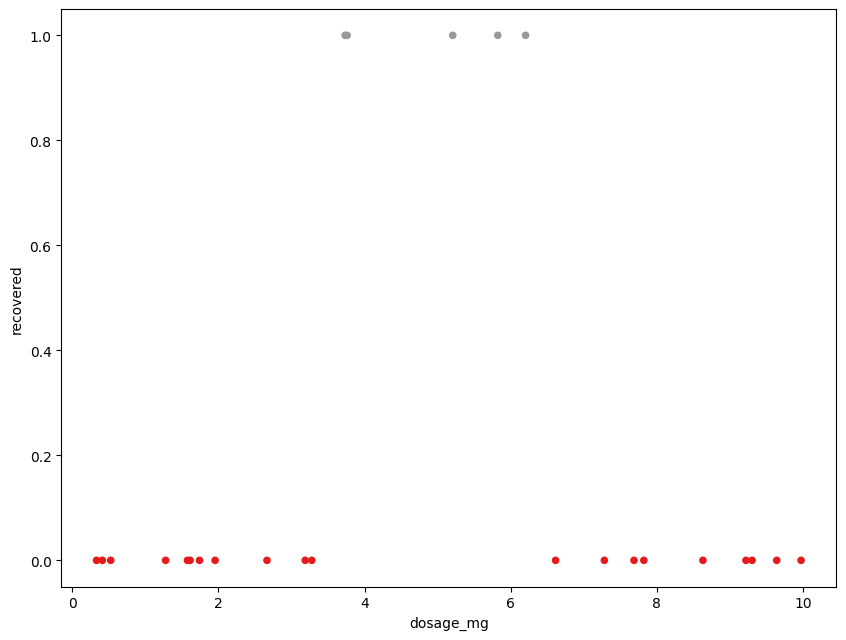

In [3]:
np.random.seed(135)

patients_df = pd.DataFrame({
    "dosage_mg": 10 * np.random.random(size=25)
})

recovered = (3.7 < patients_df["dosage_mg"]) & (patients_df["dosage_mg"] < 6.54)

patients_df["recovered"] = recovered.astype(int)
patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(10, 7.5), colorbar=False)

Obliczmy teraz wartości impurity dla każdego podziału.

In [4]:
def p(y, class_names):
    prob = []
    for class_name in class_names:
        try:
            prob.append(y[y == class_name].shape[0] / y.shape[0])
        except ZeroDivisionError:
            prob.append(0.0)
    return np.array(prob)

In [5]:
def gini(p):
    return np.sum(p * (1 - p))

In [6]:
def impurity(y_left, y_right, class_names, imp_fn=gini):
    n_left = y_left.shape[0]
    n_right = y_right.shape[0]
    N = n_left + n_right
    p_left = p(y_left, class_names)
    p_right = p(y_right, class_names)
    return (n_left / N) * imp_fn(p_left) + (n_right / N) * imp_fn(p_right)

Kolejny raz będziemy wykorzystywać pośrednie wartości pomiędzy parami sąsiednich dawek jako potencjalnie miejsca podziału. Mamy tylko jedną cechę, więc nie będzie potrzeby, aby dodatkowo testować różne możliwości na tym poziomie - typowo jednak nie będzie aż tak prosto.

In [7]:
sorted_patients_df = patients_df.sort_values("dosage_mg", ascending=True)
thresholds = sorted_patients_df["dosage_mg"].rolling(2).mean()
thresholds

14         NaN
18    0.370912
8     0.468227
11    0.901095
5     1.426026
21    1.593392
13    1.675980
2     1.847289
20    2.308727
22    2.925131
1     3.231868
10    3.505071
12    3.747177
6     4.483607
24    5.514322
15    6.012739
0     6.408091
17    6.947133
19    7.483763
4     7.753936
3     8.225573
23    8.924132
9     9.260539
7     9.471096
16    9.806038
Name: dosage_mg, dtype: float64

In [8]:
def calculate_impurity(threshold, df):
    y_left = df[df["dosage_mg"] <= threshold]["recovered"]
    y_right = df[df["dosage_mg"] > threshold]["recovered"]
    return impurity(y_left, y_right, [0, 1])

def create_impurities_df(df):
    sorted_df = df.sort_values("dosage_mg", ascending=True)
    
    thresholds = sorted_df["dosage_mg"].rolling(2).mean()
    impurities_df = pd.DataFrame({
        "threshold": thresholds.dropna()
    })
    impurities_df["impurity"] = impurities_df["threshold"].map(lambda t: calculate_impurity(t, df))
    return impurities_df

In [9]:
impurities_df = create_impurities_df(patients_df)
impurities_df.nsmallest(n=5, columns="impurity")

,threshold,impurity
10,3.505071,0.257143
1,3.231868,0.266667
22,2.925131,0.275000
0,6.408091,0.275000
20,2.308727,0.282353


<Axes: xlabel='threshold', ylabel='recovered'>

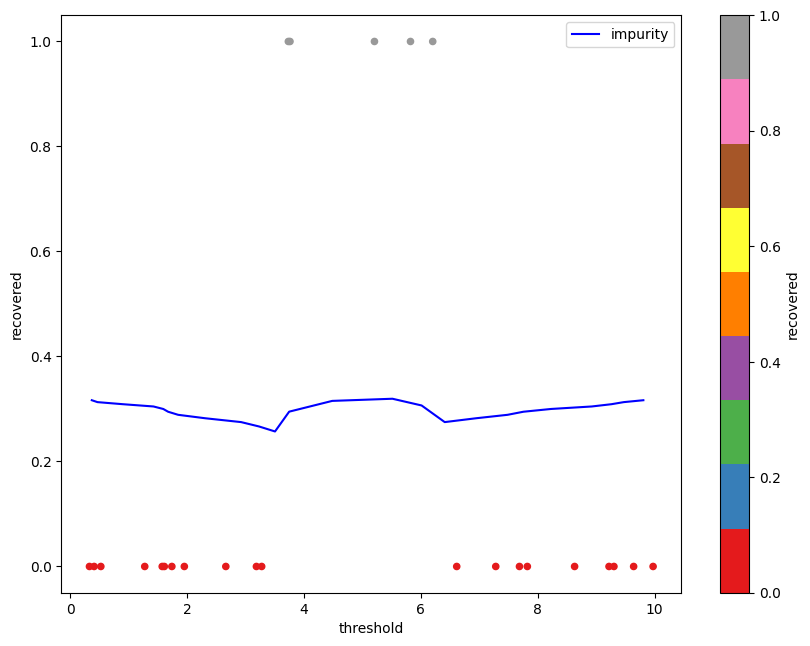

In [10]:
ax = patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(10, 7.5))
impurities_df.plot.line(x="threshold", y="impurity", c="blue", ax=ax)

Odnaleźliśmy lokalne minimum w punkcie dosage_mg = 3.505071. Podzielmy więc zbiór na lewą i prawą część, a następnie rozpatrzmy stworzone podproblemy.

In [11]:
t_0 = 3.505071

In [12]:
Q_left = patients_df[patients_df["dosage_mg"] <= t_0]
Q_right = patients_df[patients_df["dosage_mg"] > t_0]

impurities_left_df = create_impurities_df(Q_left)
impurities_right_df = create_impurities_df(Q_right)

In [13]:
import matplotlib.pyplot as plt

<Axes: xlabel='threshold', ylabel='recovered'>

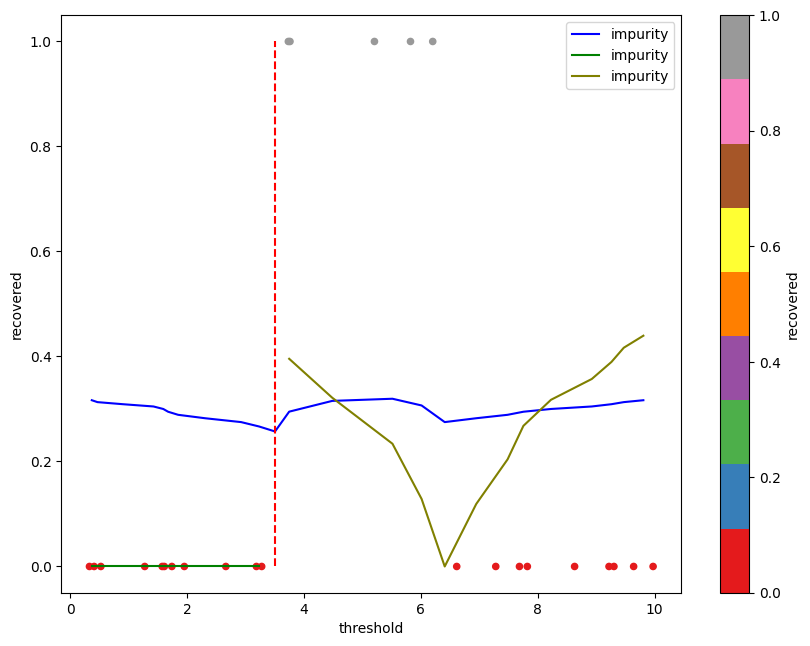

In [14]:
ax = patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(10, 7.5))
impurities_df.plot.line(x="threshold", y="impurity", c="blue", ax=ax)

plt.plot([t_0, t_0], [0, 1], "r--")
impurities_left_df.plot.line(x="threshold", y="impurity", c="green", ax=ax)
impurities_right_df.plot.line(x="threshold", y="impurity", c="olive", ax=ax)

In [15]:
impurities_right_df.nsmallest(n=5, columns="impurity")

,threshold,impurity
0,6.408091,0.000000
17,6.947133,0.119048
15,6.012739,0.128571
19,7.483763,0.204082
24,5.514322,0.233766


In [16]:
t_1 = 6.408091

In [18]:
Q_right_left = Q_right[Q_right["dosage_mg"] <= t_1]
Q_right_right = Q_right[Q_right["dosage_mg"] > t_1]

impurities_right_left_df = create_impurities_df(Q_right_left)
impurities_right_right_df = create_impurities_df(Q_right_right)

<Axes: xlabel='threshold', ylabel='recovered'>

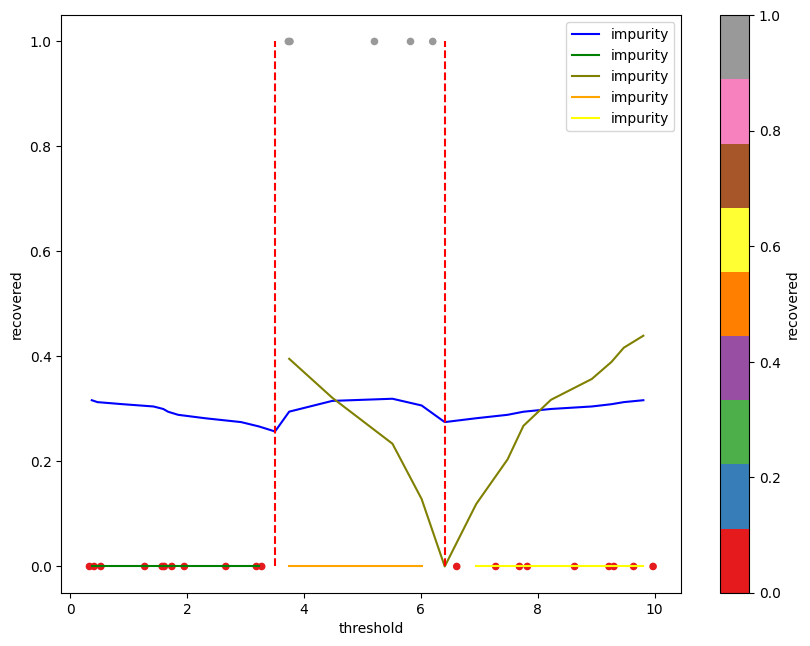

In [21]:
ax = patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(10, 7.5))
impurities_df.plot.line(x="threshold", y="impurity", c="blue", ax=ax)

plt.plot([t_0, t_0], [0, 1], "r--")
impurities_left_df.plot.line(x="threshold", y="impurity", c="green", ax=ax)
impurities_right_df.plot.line(x="threshold", y="impurity", c="olive", ax=ax)

plt.plot([t_1, t_1], [0, 1], "r--")
impurities_right_left_df.plot.line(x="threshold", y="impurity", c="orange", ax=ax)
impurities_right_right_df.plot.line(x="threshold", y="impurity", c="yellow", ax=ax)

### Automatyzacja procesu nauczania
Mieliśmy wiele szczęścia, że nasz proces nauczania zakończył się tak wcześnie. Przeprowadzenie tego procesu ręcznie byłoby bardzo uciążliwe dla bardziej skomplikowanych zbiorów. Na całe szczęście istnieje gotowa implementacja, która jest dostępna w bibliotece scikit-learn i pozwala przeprowadzić ten sam proces w sposób automatyczny.


In [22]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
dt = DecisionTreeClassifier(criterion="gini")
dt.fit(patients_df.drop(columns="recovered"), patients_df["recovered"])


DecisionTreeClassifier()

In [25]:
from sklearn.tree import export_text

In [26]:
print(export_text(dt, decimals=6))

|--- feature_0 <= 3.505071
|   |--- class: 0
|--- feature_0 >  3.505071
|   |--- feature_0 <= 6.408091
|   |   |--- class: 1
|   |--- feature_0 >  6.408091
|   |   |--- class: 0



Nauczone drzewo wygląda dość podobnie do tego, które przed chwilą stworzyliśmy ręcznie, więc chyba znamy już generalną zasadę jak uczyć tego rodzaju modele. Czemu jednak Gini impurity to nie jest jedyna z możliwych opcji pomiaru jakości?